#### GradientBoosting Classifier on news and news sentiment 

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, confusion_matrix, roc_auc_score, precision_score
from sklearn.svm import SVC
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import plot_confusion_matrix

import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from keras.callbacks import EarlyStopping

In [3]:
apple = pd.read_csv('data/AppleNewsStock.csv')

In [10]:
# drop rows with missing news column
apple.dropna(axis = 0, inplace = True)

In [11]:
apple.columns = apple.columns.str.lower()

In [12]:
# engineer a variable up or down 
apple['up_or_down'] = apple['adj close'] - apple['open']

In [13]:
# create a function for up or down column
def up_or_down(number):
    if number < 0:
        return 'down'
    if number > 0:
        return 'up'   

In [14]:
# apply function
apple['up_or_down'] = apple['up_or_down'].apply(up_or_down)

In [15]:
# set date as index column
apple.set_index(['date'], inplace = True)

### Countvectorizing news articles

In [24]:
cvect_apple = CountVectorizer(stop_words = 'english', ngram_range = (3,3), max_features = 500)

In [25]:
news_vect_apple = cvect_apple.fit_transform(apple['news'])

In [26]:
apple_vect = pd.DataFrame(news_vect_apple.toarray(), columns = cvect_apple.get_feature_names())

### Sentiment Analysis: Apple

In [32]:
sentiment_objects_apple = [TextBlob(i) for i in apple['news']]

In [33]:
sentiment_values_apple = [[i.sentiment.polarity, str(i)] for i in sentiment_objects_apple]

In [34]:
sentiment_df_apple = pd.DataFrame(sentiment_values_apple, columns = ['polarity', 'news'])

In [37]:
sentiment_df_apple = sentiment_df_apple[sentiment_df_apple.polarity != 0]

In [38]:
sentiment_df_apple.mean()

polarity    0.111278
dtype: float64

In [40]:
# concat polarity df with apple df on 'news'
apple_final = pd.merge(apple, sentiment_df_apple, on='news')

In [41]:
# dropping rows with missing values
apple_final.dropna(axis = 0, inplace = True)

In [42]:
# save to csv 
apple_final.to_csv('data/apple_clean.csv')

In [43]:
# add polarity to countvectorized dataframe
apple_vect['polarity'] = apple_final['polarity']

In [44]:
# add y value to countvectorized dataframe
apple_vect['up_or_down'] = apple_final['up_or_down']

In [45]:
apple_vect.dropna(axis = 0, inplace = True)

In [46]:
apple_vect.to_csv('data/apple_vect_clean.csv')

### Null Model

In [47]:
apple_final['up_or_down'].value_counts(normalize=True) # null model is just a little over 50% accurate

up      0.505837
down    0.494163
Name: up_or_down, dtype: float64

### Train Test Split

In [48]:
X = apple_vect.drop(columns = 'up_or_down')
y = apple_vect['up_or_down']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

### 3. GradientBoosting

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

In [58]:
pipe_boost = make_pipeline(GradientBoostingClassifier())

In [59]:
pipe_boost.fit(X_train, y_train)

Pipeline(steps=[('gradientboostingclassifier', GradientBoostingClassifier())])

In [60]:
pipe_boost.score(X_train, y_train)

0.6528258362168397

In [61]:
pipe_boost.score(X_test, y_test)

0.5164075993091537

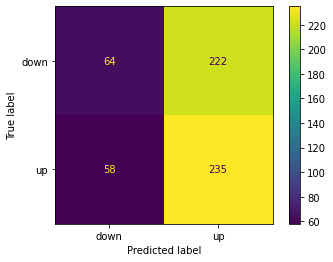

In [75]:
# plot confusion matrix 
plot_confusion_matrix(pipe_boost, X_test, y_test);